### Importações

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from circulo import obter_pontos_circulo_cheio

### Estruturas de dados

A classe `AutomatoCelular`, gera as estruturas principais do autômato celular contador de distâncias.

Para cada célula existe uma tupla com quatro valores (id_material, dx, dy, dz), mas nesse exeplo
o material vai ser constante. E em vez de usar valores de tuplas para cada celula de matriz, iremos criar três matrizes distintas com os valores para cada indice da tupla do modelo de Colombo.

A matriz de ativação (ativado) define o estado de propagação, verdadeiro para quando a célula já realizou o seu devido trabalho.

In [245]:
class AutomatoCelular:
    def __init__(self, tamanho_malha=0, dmin=0, dmax=0):
        self.tamanho_malha = tamanho_malha
        self.dmin = dmin
        self.dmax = dmax
        self.id = np.full((tamanho_malha, tamanho_malha, tamanho_malha), 0, dtype=np.int8)
        self.dx = np.full((tamanho_malha, tamanho_malha, tamanho_malha), np.inf)
        self.dy = np.full((tamanho_malha, tamanho_malha, tamanho_malha), np.inf)
        self.dz = np.full((tamanho_malha, tamanho_malha, tamanho_malha), np.inf)
        self.ativado = np.zeros((tamanho_malha, tamanho_malha, tamanho_malha), dtype=bool) 

    def set(self, i, j, k, valor=(0,0,0)):
        self.dx[i,j,k], self.dy[i,j,k], self.dz[i,j,k] = valor

    def get(self, i, j, k):
        return self.dx[i,j,k], self.dy[i,j,k], self.dz[i,j,k]

    def ativar(self, i, j, k):
        self.ativado[i,j,k] = True

    def magnitude_total(self):
        return np.sqrt(self.dx**2 + self.dy**2 + self.dz**2) * self.dmin

    def magnitude(self, dx, dy, dz):
        return np.sqrt(dx**2 + dy**2 + dz**2) * self.dmin

    def set_id(self, i,j,k, id):
        self.id[i,j,k] = id

    def get_id(self, i,j,k):
        return self.id[i,j,k]
        


### Funções especiais

- Função de processamento, no processo de autômatos o valor da célula é definida dependendo de seu estado e dos seus vizinhos, mas para questão de otimização do modelo de Colombo, em vez de ter uma segunda matriz de dados, o autor propós usar a célula atual para propagar sua informação entre seus vizinhos, caso ela for a melhor escolha.
- Em seu método de otimização, foi proposto usar uma lista para armazenar as células que representam a frente de onda, assim é possível mapear toda a matriz e ao mesmo tempo processar a propagação da informação das frentes de ondas.

In [224]:
def processar(ac, pontos_emissao):

    # Fila de processamento da propagação da frente de onda
    frente_onda = deque()
    frente_onda_buffer = deque()

    # Inicializando os pontos de emissão
    for i, j, k in pontos_emissao:
        ac.set(i,j,k)
        ac.ativar(i,j,k)
        ac.set_id(i,j,k, 0)
        frente_onda.append((i, j, k))

    dpassos = 0
    
    # Enquanto tiver frentes de onda para propagar
    while frente_onda:
        
        # Removendo a primeira célula da frente de onda
        i, j, k = frente_onda.popleft()

        # Distância pertecente a célula atual
        distancia_atual = ac.get(i,j,k)
        
        # Se tiver dentro das limites de espessura remove o material
        if ac.magnitude(*distancia_atual) <= ac.dmax and ac.get_id(i,j,k) == 1:
            ac.set_id(i,j,k, 0)

        # Vetores unitários dos vizinhos da célula
        vetores = [
            ( 1,  0,  0), # Direita
            (-1,  0,  0), # Esquerda
            ( 0,  1,  0), # Cima
            ( 0, -1,  0), # baixo
            ( 0,  0,  1), # frente
            ( 0,  0, -1)  # atrás
        ]

        # Percorrendo os vizinhos
        for vi, vj, vk in vetores:
            # Posição do vizinho
            pos_i, pos_j, pos_k = i+vi, j+vj, k+vk

            # Verifica a célula pertence a malha
            namalha = lambda v_: 0 <= v_ < ac.tamanho_malha
            if namalha(pos_i) and namalha(pos_j) and namalha(pos_k):

                if ac.get_id(pos_i, pos_j, pos_k) == 3:
                    continue
                
                # Calcula as novas distâncias do vizinho
                novo_dx = distancia_atual[0] + abs(vi)
                novo_dy = distancia_atual[1] + abs(vj)
                novo_dz = distancia_atual[2] + abs(vk)
                nova_distancia = ac.magnitude(novo_dx, novo_dy, novo_dz)
                
                # Distância atual do vizinho
                vdx, vdy, vdz = ac.get(pos_i, pos_j, pos_k)
                distancia_vizinho = ac.magnitude(vdx, vdy, vdz)

                # Define para o vizinho a melhor distância
                if nova_distancia < distancia_vizinho and nova_distancia <= ac.dmax:
                    
                    # Atualiza com a melhor distância
                    ac.set(pos_i, pos_j, pos_k, valor=(novo_dx, novo_dy, novo_dz))

                    # Adiciona o vizinho para ser uma nova frente de onda
                    ac.ativar(pos_i, pos_j, pos_k)
                    frente_onda_buffer.append((pos_i, pos_j, pos_k))

        if not frente_onda:
            dpassos += 1
            frente_onda.extend(frente_onda_buffer)
            frente_onda_buffer.clear()

    return dpassos - 1
        

- Função de visualização, ela mostra a estrutura do material no seu estado final.

In [185]:
def visualizacao(automato, elevacao=30, azimute=45):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define quais espaços terão voxels (IDs 1 ou 3)
    voxels = (automato.id == 1) | (automato.id == 3)
    
    # Cria uma matriz de cores do mesmo tamanho da grade
    # Inicializamos com cores transparentes ou vazias
    cores = np.empty(automato.id.shape, dtype=object)
    
    # Atribui as cores baseadas no ID
    cores[automato.id == 1] = '#D3D3D3'  # Cinza para ID 1
    cores[automato.id == 3] = '#FF0000'  # Vermelho para ID 3 (Red)

    # Plota os voxels usando a matriz de cores
    ax.voxels(voxels, facecolors=cores, edgecolor='#808080', shade=True)
    
    ax.view_init(elev=elevacao, azim=azimute)
    ax.set_xlabel('Eixo X')
    ax.set_ylabel('Eixo Y')
    ax.set_zlabel('Eixo Z')
    
    ax.set_xlim(0, automato.tamanho_malha)
    ax.set_ylim(0, automato.tamanho_malha)
    ax.set_zlim(0, automato.tamanho_malha)
    ax.set_box_aspect([1, 1, 1]) 
    
    plt.tight_layout()
    plt.show()

# Simulações


In [284]:
TAM = 101
ac1 = AutomatoCelular(TAM, dmin=1, dmax=(TAM//2)-1)

ac1.id[:,:,:TAM-1] = 1
for i, j in  obter_pontos_circulo_cheio(TAM, (TAM//2)-1):
    ac1.set_id(i, j, TAM-1, 3)

pontos_emissao = list(zip(*np.where(ac1.id == 0)))
processar(ac1, pontos_emissao)

83

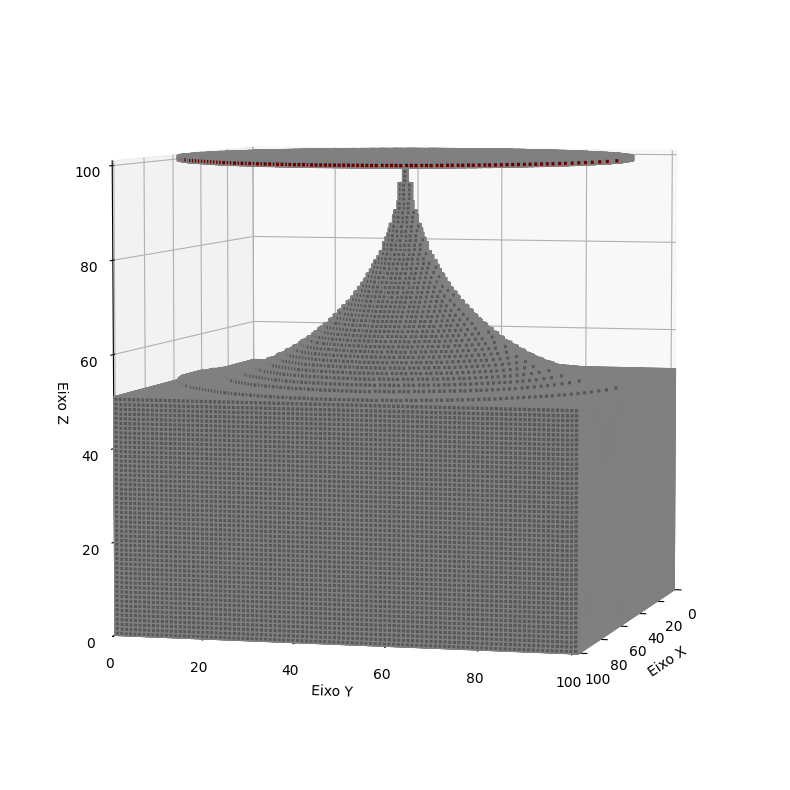

In [285]:
# azimute = 45|135|225|315
visualizacao(ac1, elevacao=5,azimute=15)